In [1]:
%matplotlib inline

# Data Augmentation
Data augmentation is a technique to artificially generate more data by transforming the available training samples, for example, by translation, rotation, changing brightness etc. It is specially useful when our training set is small and your model requires more data in order to learn properly.

## Imports
First let's import some prerequisites:

In [10]:
import numpy as np
from random import seed
seed(42)

import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from sklearn.cross_validation import StratifiedShuffleSplit

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

#Keras class to augment data
from keras.preprocessing.image import ImageDataGenerator

## Load and prepare data
We will use CIFAR-10 dataset, but we will simulate a scenario where we lack training data. To do this, instead of using the usual train/val/test splits, we will have 10k images for training, 10k for validation and 40k for testing. 

In [3]:
#Load data
(testVal_data, testVal_label), (X_train, y_train) = cifar10.load_data()

#Split trainVal data into train and val sets (already balanced)
splitIdx = StratifiedShuffleSplit(testVal_label, 1, test_size=0.8, random_state=0)
for val_index, test_index in splitIdx:
    X_val, X_test = testVal_data[val_index], testVal_data[test_index]
    y_val, y_test = testVal_label[val_index], testVal_label[test_index]
    
#Transform data
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape, "<----- Small training set")
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 121s 1us/step
Training matrix shape (10000, 32, 32, 3) <----- Small training set
Validation matrix shape (10000, 32, 32, 3)
Testing matrix shape (40000, 32, 32, 3)


Let's look at some examples of the training data:

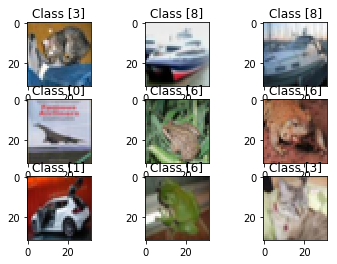

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Class {}".format(y_train[i]))
plt.show()

# Architecture
We will use one of the architectures used in an earlier example. It has only a single convolutional layer with 20 5x5 filters, a max pooling and a fully-connected layer with 10 neurons (the same size as the number of classes in CIFAR-10).

We will define two equal models, in which we will train one with data augmentation and another without.

In [5]:
modelList = [Sequential(), Sequential()]
for i in list(range(2)):
    # Define your model here
    model = modelList[i]

    #Conv layer with 20 filters of size 5x5 and ReLU activation
    model.add(Conv2D(20, kernel_size=(5, 5),
    activation='relu', #ReLU activation
    input_shape=(32,32,3))) #no need to include the batch size
    
    #Max pooling of size 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Flatten operation
    model.add(Flatten())

    #FC layer with 10 neurons and softmax activation
    model.add(Dense(10, activation='softmax'))

    #Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    modelList.append(model)

modelWithDA = modelList[0]
modelWithoutDA = modelList[1]

## Data Augmentation
Keras make the class [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) available to augment data. It allows a wide range of transformations on the input data and, in this exercise, we will **flip the image horizontally**, **rotate the image by a few degrees**, **translate the image in both directions by at most 1% of the height or width**.

At each batch, the generator will apply these transformations with random parameters. 

In [6]:
trainDataGen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range=0.01, 
                                  width_shift_range=0.01, 
                                  height_shift_range=0.01)

## Train the model with and without Data Augmentation!
We will train for 10 epochs (it is a small number for the sake of demonstration, but you should try more later) with batches of 128 images.

In [7]:
print("-----> Fitting without Data Augmentation")
# fits the model without data augmentation
modelWithoutDA.fit(X_train, Y_train, batch_size=128, epochs=10,
                  validation_data=(X_val, Y_val))

print("\n\n-----> Fitting with Data Augmentation")
# fits the model on batches with real-time data augmentation:
modelWithDA.fit_generator(trainDataGen.flow(X_train, Y_train, batch_size=128), 
                          steps_per_epoch=len(X_train) / 128, epochs=10,
                          validation_data=(X_val, Y_val))



-----> Fitting without Data Augmentation
Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 11s 1ms/step - loss: 2.2346 - acc: 0.1777 - val_loss: 2.2039 - val_acc: 0.1817
Epoch 2/10
10000/10000 [==============================] - 13s 1ms/step - loss: 2.1000 - acc: 0.2427 - val_loss: 2.1692 - val_acc: 0.1858
Epoch 3/10
10000/10000 [==============================] - 12s 1ms/step - loss: 2.0162 - acc: 0.2810 - val_loss: 2.1181 - val_acc: 0.2394
Epoch 4/10
10000/10000 [==============================] - 12s 1ms/step - loss: 1.9716 - acc: 0.3000 - val_loss: 2.0177 - val_acc: 0.2695
Epoch 5/10
10000/10000 [==============================] - 8s 810us/step - loss: 1.9397 - acc: 0.3160 - val_loss: 2.0140 - val_acc: 0.2694
Epoch 6/10
10000/10000 [==============================] - 8s 825us/step - loss: 1.9070 - acc: 0.3317 - val_loss: 1.9890 - val_acc: 0.2817
Epoch 7/10
10000/10000 [==============================] - 8s 810us/step - loss: 1.880

## Finally, evaluate its performance on the test data

In [8]:
scoreWithourDA = modelWithoutDA.evaluate(X_test,Y_test,verbose=1)
print('[Without DA]Test loss:', scoreWithourDA[0])
print('[Without DA]Test accuracy (NORMALIZED):', scoreWithourDA[1])

print("\n")

scoreWithDA = modelWithDA.evaluate(X_test,Y_test,verbose=1)
print('[DA]Test loss:', scoreWithDA[0])
print('[DA]Test accuracy (NORMALIZED):', scoreWithDA[1])

40000/40000 [==============================] - 12s 296us/step
[Without DA]Test loss: 2.0136388555526734
[Without DA]Test accuracy (NORMALIZED): 0.275375


40000/40000 [==============================] - 13s 337us/step
[DA]Test loss: 1.806400389957428
[DA]Test accuracy (NORMALIZED): 0.373675


# Early Stopping
Keras has a lot of [callbacks](https://keras.io/callbacks/), which are functions that can be applied at given stages of the training procedure. One of them implements an [early stopping](https://keras.io/callbacks/#earlystopping) mechanism.

It monitors a metric you chose, e.g., loss on the validation set, and if it does not improve for a number of epochs, the training is stopped. An example of usage would be:

In [11]:
# Model definition
#model = Sequential()
#model.add(...)

# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', #metric to monitor
                          min_delta=0.0001,  #difference considered as improvement
                          patience=5) #number of epochs with no improvement after which training will be stopped 

callbacks_list = [earlystop]

# train the model
model_info = model.fit(X_train, Y_train, batch_size=128, epochs=100, 
                       callbacks=callbacks_list)  # <---- pass the list of callbacks

Epoch 1/100
10000/10000 [==============================] - 5s 540us/step - loss: 1.7744 - acc: 0.3876
Epoch 2/100
  384/10000 [>.............................] - ETA: 5s - loss: 1.8231 - acc: 0.3490

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


10000/10000 [==============================] - 5s 542us/step - loss: 1.7479 - acc: 0.3970
Epoch 3/100
10000/10000 [==============================] - 5s 531us/step - loss: 1.7222 - acc: 0.4049
Epoch 4/100
10000/10000 [==============================] - 6s 571us/step - loss: 1.6963 - acc: 0.4149
Epoch 5/100
10000/10000 [==============================] - 6s 591us/step - loss: 1.6763 - acc: 0.4232
Epoch 6/100
10000/10000 [==============================] - 7s 702us/step - loss: 1.6465 - acc: 0.4301
Epoch 7/100
10000/10000 [==============================] - 7s 727us/step - loss: 1.6263 - acc: 0.4303
Epoch 8/100
10000/10000 [==============================] - 7s 712us/step - loss: 1.6049 - acc: 0.4435
Epoch 9/100
10000/10000 [==============================] - 7s 717us/step - loss: 1.5785 - acc: 0.4554
Epoch 10/100
10000/10000 [==============================] - 7s 693us/step - loss: 1.5677 - acc: 0.4570
Epoch 11/100
10000/10000 [==============================] - 7s 739us/step - loss: 1.5499 - ac

10000/10000 [==============================] - 6s 585us/step - loss: 1.0679 - acc: 0.6349
Epoch 82/100
10000/10000 [==============================] - 6s 641us/step - loss: 1.0637 - acc: 0.6393
Epoch 83/100
10000/10000 [==============================] - 6s 618us/step - loss: 1.0600 - acc: 0.6413
Epoch 84/100
10000/10000 [==============================] - 6s 615us/step - loss: 1.0504 - acc: 0.6438
Epoch 85/100
10000/10000 [==============================] - 6s 585us/step - loss: 1.0498 - acc: 0.6428
Epoch 86/100
10000/10000 [==============================] - 6s 560us/step - loss: 1.0498 - acc: 0.6395
Epoch 87/100
10000/10000 [==============================] - 6s 552us/step - loss: 1.0429 - acc: 0.6447
Epoch 88/100
10000/10000 [==============================] - 6s 569us/step - loss: 1.0490 - acc: 0.6451
Epoch 89/100
10000/10000 [==============================] - 6s 556us/step - loss: 1.0380 - acc: 0.6515
Epoch 90/100
10000/10000 [==============================] - 6s 553us/step - loss: 1.03

# References

- [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class)